In [1]:
import numpy as np
import torch
import torch.nn as nn
import torchvision
from torchvision import datasets, transforms
from torch.autograd import Variable

from lenet import Net
import matplotlib.pyplot as plt
from utils import to_numpy_array, pgd_linf


c:\Users\malay\miniconda3\envs\cs776\lib\site-packages\tqdm\auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [3]:
classifier = Net()
classifier.to(device)
classifier.load_state_dict(torch.load('./models/lenet_mnist_model.pth'))

<All keys matched successfully>

In [4]:
transform=transforms.Compose([
            transforms.ToTensor(),
])

dataset = datasets.MNIST(root= './data', train = True, download =True, transform = transform)
train_loader = torch.utils.data.DataLoader(dataset, batch_size=16, shuffle=True)

In [5]:
epsilons = [0, .05, .1, .15, .2, .25, .3]
accs = []

In [8]:
for eps in epsilons:

    correct, total = 0, 0

    for i, (imgs, labels) in enumerate(train_loader):
        imgs, labels = imgs.to(device), labels.to(device)
        imgs, labels = Variable(imgs, requires_grad=True), Variable(labels)

        delta = pgd_linf(classifier, imgs, labels, eps, alpha=1e-2, num_iter=40)

        y_preds = classifier(imgs + delta).argmax(dim=1)

        correct += (y_preds==labels).sum().item()
        total += labels.size(0)

    print("Epsilon: {}, Test Accuracy: {:.4f}".format(eps, correct / total))
    
    accs.append((correct / total))

Epsilon: 0, Test Accuracy: 0.9429
Epsilon: 0.05, Test Accuracy: 0.7938
Epsilon: 0.1, Test Accuracy: 0.4097
Epsilon: 0.15, Test Accuracy: 0.1188
Epsilon: 0.2, Test Accuracy: 0.0275
Epsilon: 0.25, Test Accuracy: 0.0087
Epsilon: 0.3, Test Accuracy: 0.0041


In [10]:
plt.plot(epsilons, accs, "*-")
plt.xlabel("Epsilon")
plt.xlabel("Accuracy")
plt.title("Epsilon vs Accuracy")
plt.savefig('./plots/epsilon_vs_accuracy_pgd_mnist.png', transparent=False)
plt.close()

c:\Users\malay\miniconda3\envs\cs776\lib\site-packages\ipykernel_launcher.py:43: UserWarning: Matplotlib is currently using module://matplotlib_inline.backend_inline, which is a non-GUI backend, so cannot show the figure.


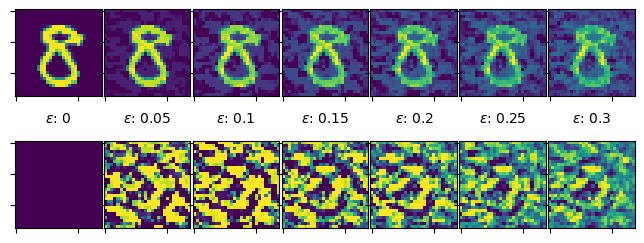

In [11]:
for i, (imgs, labels) in enumerate(train_loader):
    imgs, labels = imgs.to(device), labels.to(device)
    imgs, labels = Variable(imgs, requires_grad=True), Variable(labels)

    plot_name = f'./plots/pgd_attack_mnist.png'

    f = plt.figure(figsize=(8,4))
    gs = f.add_gridspec(2, len(epsilons))
    gs.update(wspace=0.025, hspace=-0.25) 

    for i in range(len(epsilons)):
        eps = epsilons[i]
        ax1 = f.add_subplot(gs[0,i])
        imgs, labels = imgs.to(device), labels.to(device)
        imgs, labels = Variable(imgs, requires_grad=True), Variable(labels)

        adv_imgs, _ = pgd_linf(classifier, imgs, labels, epsilon=eps, alpha=1e-2, num_iter=40)

        img, adv_img = imgs[0], adv_imgs[0]
        img, adv_img = to_numpy_array(img), to_numpy_array(adv_img)

        ax1.imshow(adv_img)
        ax1.set_xlabel(f"$\epsilon$: {eps}")
        ax1.set_xticklabels([])
        ax1.set_yticklabels([])

    for i in range(len(epsilons)):
        eps = epsilons[i]
        ax2 = f.add_subplot(gs[1, i])
        imgs, labels = imgs.to(device), labels.to(device)
        imgs, labels = Variable(imgs, requires_grad=True), Variable(labels)

        adv_imgs, _ = pgd_linf(classifier, imgs, labels, epsilon=eps, alpha=1e-2, num_iter=40)

        img, adv_img = imgs[0], adv_imgs[0]
        img, adv_img = to_numpy_array(img), to_numpy_array(adv_img)
        noise = adv_img - img

        ax2.imshow(noise)
        ax2.set_xticklabels([])
        ax2.set_yticklabels([])

    f.show()
    f.savefig(plot_name, transparent=False, dpi=300)
    break